In [1]:
import numpy as np
import cupy as cp
import sys
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from types import SimpleNamespace
import h5py
import dxchange
import warnings
import pandas as pd
warnings.filterwarnings("ignore", message=f".*peer.*")

sys.path.insert(0, '..')
from utils import *
from rec import Rec

astropy module not found
olefile module not found


In [2]:
bin = 3
ntheta = 60
path = f'/data/vnikitin/ESRF/ID16A/20240924_rec_ca/data/'
with  h5py.File(f'{path}/data_atomium.h5','r') as fid:
    code = fid[f'/exchange/code'][:].astype('complex64')
    q = fid[f'/exchange/prb'][:].astype('complex64')    
    shifts_cor = fid[f'/exchange/shifts_cor'][::7200//ntheta].astype('float32')
    shifts_code = fid[f'/exchange/shifts_code'][::7200//ntheta].astype('float32')    
    z1 = fid['/exchange/z1'][0]
    detector_pixelsize = fid['/exchange/detector_pixelsize'][0]
    focusdetectordistance = fid['/exchange/focusdetectordistance'][0]
    energy = fid['/exchange/energy'][0]

with  h5py.File(f'{path}/data_ca.h5','r') as fid:
    z1c = fid['/exchange/z1'][0] 

for k in range(bin):
    q = 0.5*(q[::2]+q[1::2])
    q = 0.5*(q[:,::2]+q[:,1::2])
    code = 0.5*(code[::2]+code[1::2])
    code = 0.5*(code[:,::2]+code[:,1::2])
shifts_cor/=2**bin
shifts_code/=2**bin
# v = np.arange(-q.shape[-1]//2,q.shape[-1]//2)/q.shape[-1]
# [vx,vy] = np.meshgrid(v,v)
# v=np.exp(-20*(vx**2+vy**2))
# q = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(q)))
# q = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(q*v)))
# q = q.astype('complex64')

# v = np.arange(-code.shape[-1]//2,code.shape[-1]//2)/q.shape[-1]
# [vx,vy] = np.meshgrid(v,v)
# v=np.exp(-0.2*(vx**2+vy**2))
# code = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(code)))
# code = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(code*v)))
# code = code.astype('complex64')


In [3]:
wavelength = 1.24e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
z2 = focusToDetectorDistance-z1
distance = (z1*z2)/focusToDetectorDistance
magnification = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnification)  # object voxel size
magnifications2 = z1/z1c
distancec = (z1-z1c)/(z1c/z1)
show = True

In [4]:
args = SimpleNamespace()
args.ngpus = 4
args.lam = 50

args.n = 2048//2**bin
voxelsize *= 2048/args.n

args.ntheta = ntheta
args.ncode = 8192*args.n//2048
args.pad = 0
args.npsi = args.n + 2 * args.pad
args.nq = args.n + 2 * args.pad
args.ex = 16
args.npatch = args.nq + 2 * args.ex
args.nchunk = 32

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distance
args.distancec = distancec
args.eps = 1e-8
args.rho = [1, 20, 10]
args.path_out = f"/data/vnikitin/ESRF/ID16A/20240924_rec_ca/rec_atomium_syn/r_{args.lam}_{args.pad}"
args.show = show

args.niter=128
args.vis_step=4
args.err_step=4
args.rotation_axis=args.npsi/2

args.theta = cp.linspace(0,np.pi,ntheta).astype('float32')
# create class
cl_rec = Rec(args)


In [5]:
q = np.pad(q,((args.pad,args.pad),(args.pad,args.pad)),'symmetric')

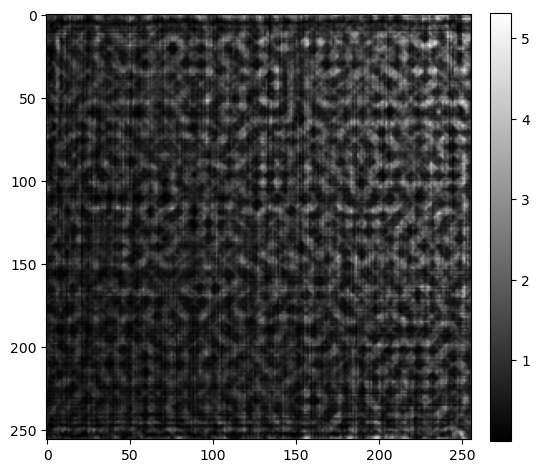

In [6]:
u = 4e3*cp.load(f'/data/vnikitin/syn_3d_ald/u{args.n}.npy').astype('complex64')
u = np.pad(u,((args.pad,args.pad),(args.pad,args.pad),(args.pad,args.pad)),'edge')
u[:] = 0
shifts_code = cp.array(shifts_code)
shifts_cor = cp.array(shifts_cor)
code = cp.array(code)
q = cp.array(q)

ri = shifts_code.astype('int32')
r = shifts_code-shifts_code.astype('int32')
rpsi = shifts_cor
data = cp.abs(cl_rec.D(cl_rec.Dc(q*cl_rec.S(ri,r,code))))**2

mshow(data[0],args.show)

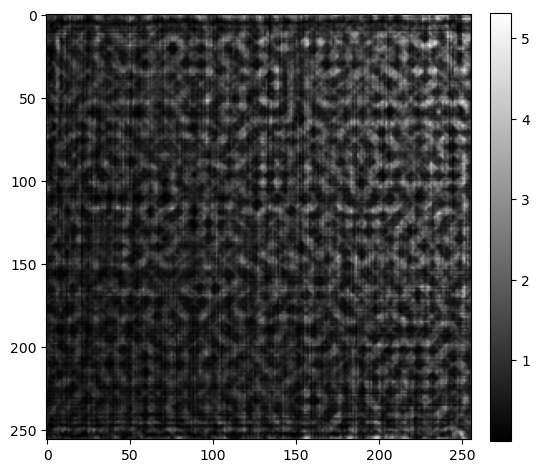

In [7]:
data_ref = cp.abs(cl_rec.D(cl_rec.Dc(q*cl_rec.S(ri,r,code))))**2
mshow(data_ref[0],args.show)

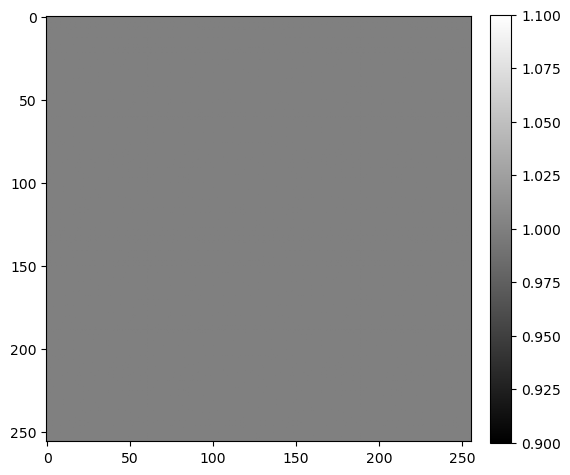

In [8]:
srrdata=data/data_ref
mshow(srrdata[0],True)

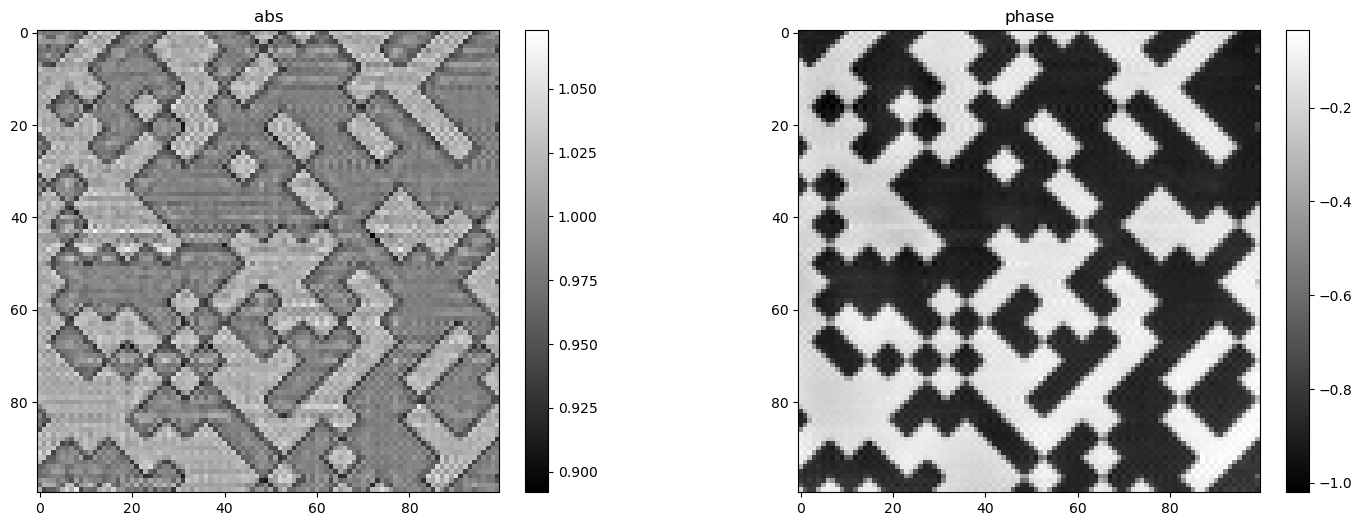

In [9]:
t = cl_rec.S(ri,r,code)
mshow_polar(t[3,:100,:100],True)

In [13]:
a = code
b = cl_rec.D(cl_rec.S(ri,r,a))
c = cl_rec.ST(cl_rec.DT(b),ri,r)
print(cp.sum(a*c.conj()))
print(cp.sum(b*b.conj()))

(3893112+0.016729772j)
(3893112-2.866183e-05j)


0) err=2.08687e+05
0.008880242 42819224.0 4821853000.0


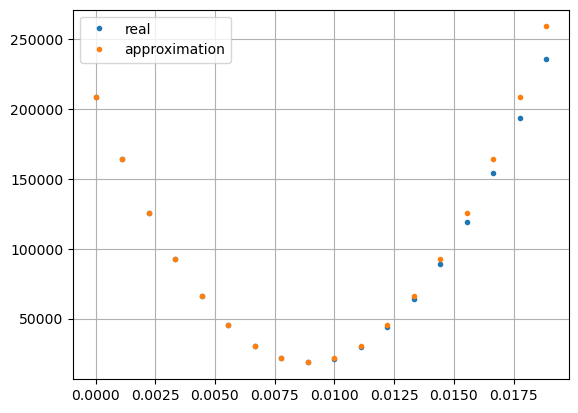

1) err=1.85831e+04
beta=np.float32(0.0062205987)
0.024101768 327348.5 13581929.0


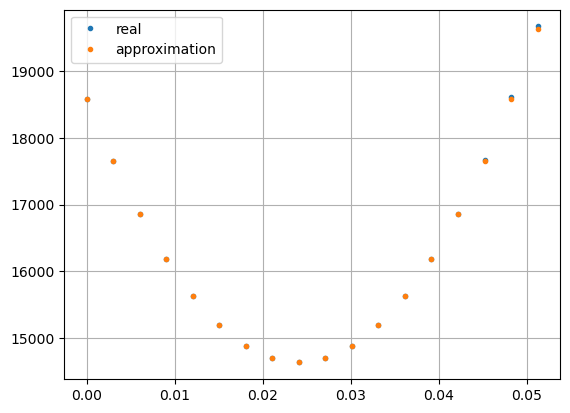

2) err=1.46347e+04
beta=np.float32(1.1886632)
0.03636646 392835.75 10802145.0


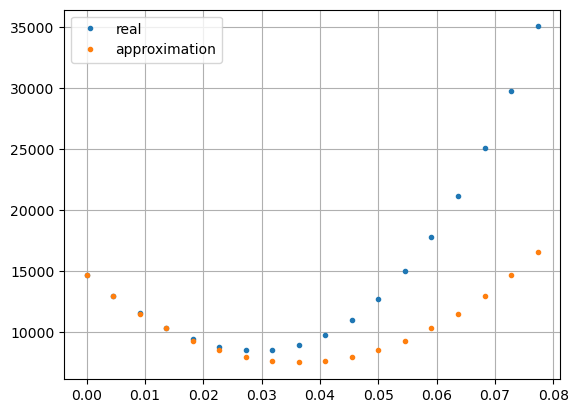

3) err=8.92054e+03
beta=np.float32(0.874489)
0.01287399 264689.34 20560008.0


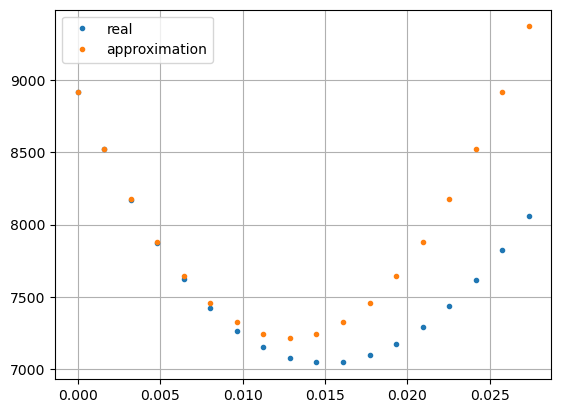

In [10]:
vars = {}
vars["code"] = cp.array(code)
vars["q"] = cp.array(q)*0+1
vars["ri"] = shifts_code.astype("int32")
vars["r_init"] = shifts_code - vars["ri"].astype("int32")
vars["r"] = vars["r_init"]
vars["table"] = pd.DataFrame(columns=["iter", "err", "time"])
cl_rec.rho = [1,1,0]
cl_rec.lam = 0 
cl_rec.vis_step=1
cl_rec.err_step=1
cl_rec.eps=0
cl_rec.niter=4
vars = cl_rec.BH(data, vars)